In [1]:
from matplotlib import pyplot as plt
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D,Conv2D, MaxPooling1D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [32]:
# Load preprocessed file
with h5py.File('data/Xpad.h5', 'r') as hf:
    Xpad = hf['Xpad'][:]

In [33]:
df = pd.read_parquet("data/bookingID.parquet")

In [34]:
# Inspect label and feature shape
print(df.shape)
print(Xpad.shape)
assert df.shape[0] == Xpad.shape[0]

(19863, 3)
(19863, 1000, 11)


In [35]:
# reshape to 2d
num_timestep = Xpad.shape[1]
num_feature = Xpad.shape[2]
X = Xpad.reshape(Xpad.shape[0], num_timestep*num_feature)

In [36]:
# take only label 0 and 1
y = df['label'].values

In [42]:
# sanity check
rnd = np.random.randint(0,Xpad.shape[0]-1, size=2)
assert np.array_equal(Xpad[rnd[0]].reshape(num_timestep*num_feature),X[rnd[0]])
assert np.array_equal(Xpad[rnd[1]].reshape(num_timestep*num_feature),X[rnd[1]])

In [43]:
# split X and y into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
# inspect class imbalance
pd.DataFrame(y_train, columns=['y'])\
.reset_index()\
.groupby('y', as_index=False)\
.count()\
.rename(columns={'index':'count'})

,y,count
0,0.0,11901
1,1.0,3989


In [45]:
# inspect class imbalance
pd.DataFrame(y_test, columns=['y'])\
.reset_index()\
.groupby('y', as_index=False)\
.count()\
.rename(columns={'index':'count'})

,y,count
0,0.0,3011
1,1.0,962


In [14]:
# Architecture 1
input_shape = num_timestep * num_feature
model_m = Sequential()
model_m.add(Reshape((num_timestep, num_feature), input_shape=(input_shape,)))
model_m.add(Conv1D (kernel_size = 100, filters = 10, input_shape=(num_timestep, num_feature), activation='relu'))
print(model_m.input_shape) #debug
print(model_m.output_shape) #debug
model_m.add(MaxPooling1D(pool_size = (10), strides=(10)))
print(model_m.output_shape)
model_m.add(Reshape([20,-1,1]))   
print(model_m.output_shape)
model_m.add(Conv2D (kernel_size = (20,30), filters = 100, activation='relu'))
print(model_m.output_shape)
model_m.add(MaxPooling2D(pool_size = (1,10), strides=(1,2)))
print(model_m.output_shape)
model_m.add(Flatten())
print(model_m.output_shape)
model_m.add(Dense (128, activation='relu'))
print(model_m.output_shape)
model_m.add(Dense (64, activation='relu'))
print(model_m.output_shape)
model_m.add(Dense(1, activation = 'sigmoid',activity_regularizer=keras.regularizers.l2()))
print(model_m.output_shape)
print(model_m.summary())

(None, 11000)
(None, 901, 10)
(None, 90, 10)
(None, 20, 45, 1)
(None, 1, 16, 100)
(None, 1, 4, 100)
(None, 400)
(None, 128)
(None, 64)
(None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 1000, 11)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 901, 10)           11010     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 90, 10)            0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 20, 45, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 16, 100)        60100     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 4, 100)         0       

In [70]:
# Architecture 2
input_shape = num_timestep * num_feature
model_m = Sequential()
model_m.add(Reshape((num_timestep, num_feature), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 16, activation='relu', input_shape=(num_timestep, num_feature)))
model_m.add(Conv1D(100, 16, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 16, activation='relu'))
model_m.add(Conv1D(160, 16, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(1, activation='sigmoid'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 1000, 11)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 985, 100)          17700     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 970, 100)          160100    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 323, 100)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 308, 160)          256160    
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 293, 160)          409760    
_________________________________________________________________
global_average_pooling1d_8 ( (None, 160)               0         
__________

In [ ]:
%%time
import tensorflow as tf
from keras import backend as K

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/cnn-best_model-fixed.h5',
        monitor='val_auc', save_best_only=True, save_weights_only=False),
    keras.callbacks.EarlyStopping(monitor='auc', patience=3, mode='max', restore_best_weights=True, verbose=True) #monitor='acc'
]

model_m.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=[auc])

# Hyper-parameters
BATCH_SIZE = 16
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.1,
                      #validation_data=(X_test, y_test),
                      verbose=1)

Train on 14301 samples, validate on 1589 samples
Epoch 1/50
14301/14301 [==============================] - 35s 2ms/step - loss: 0.5776 - auc: 0.5343 - val_loss: 0.5698 - val_auc: 0.5349
Epoch 2/50
14301/14301 [==============================] - 34s 2ms/step - loss: 0.5619 - auc: 0.5366 - val_loss: 0.5631 - val_auc: 0.5472
Epoch 3/50
14301/14301 [==============================] - 34s 2ms/step - loss: 0.5499 - auc: 0.5563 - val_loss: 0.5479 - val_auc: 0.5673
Epoch 4/50
14301/14301 [==============================] - 34s 2ms/step - loss: 0.5389 - auc: 0.5779 - val_loss: 0.5555 - val_auc: 0.5874
Epoch 5/50
14301/14301 [==============================] - 34s 2ms/step - loss: 0.5370 - auc: 0.5950 - val_loss: 0.5422 - val_auc: 0.6015
Epoch 6/50
14301/14301 [==============================] - 34s 2ms/step - loss: 0.5306 - auc: 0.6073 - val_loss: 0.5348 - val_auc: 0.6128
Epoch 7/50
14301/14301 [==============================] - 34s 2ms/step - loss: 0.5297 - auc: 0.6172 - val_loss: 0.5361 - val_auc:

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


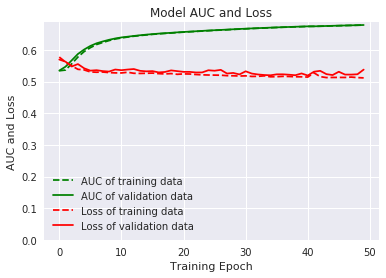

In [73]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['auc'], "g--", label="AUC of training data")
plt.plot(history.history['val_auc'], "g", label="AUC of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model AUC and Loss')
plt.ylabel('AUC and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [74]:
# check on test set
score = model_m.evaluate(X_test, y_test, verbose=1)

print("\AUC on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

3973/3973 [==============================] - 4s 904us/step
\AUC on test data: 0.68

Loss on test data: 0.51


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


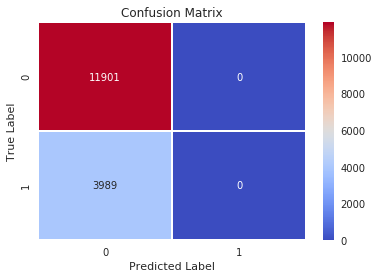

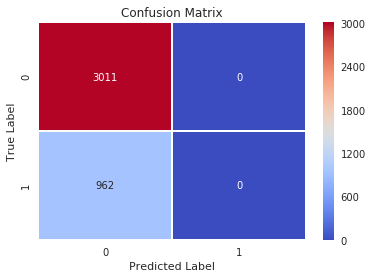

In [75]:
# Confusion matrix
y_pred_test_raw = model_m.predict(X_test).ravel()
y_pred_train_raw = model_m.predict(X_train).ravel()

y_pred_test = (y_pred_test_raw > 0.5).astype(int)
y_pred_train = (y_pred_train_raw > 0.5).astype(int)

def plot_confusion_matrix(y, y_hat):
  matrix = metrics.confusion_matrix(y, y_hat)
  plt.figure(figsize=(6, 4))
  sns.heatmap(matrix,
              cmap="coolwarm",
              linecolor='white',
              linewidths=1,
              annot=True,
              fmt="d")
  plt.title("Confusion Matrix")
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()
  
plot_confusion_matrix(y_train, y_pred_train)
plot_confusion_matrix(y_test, y_pred_test)

In [31]:
print(classification_report(y_test, y_pred_test))

             precision    recall  f1-score   support

        0.0       0.75      1.00      0.86      3006
        1.0       0.00      0.00      0.00       991

avg / total       0.57      0.75      0.65      3997



/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
fpr_train, tpr_train, thresholds_keras = roc_curve(y_train, y_pred_train_raw)
fpr_test, tpr_test, thresholds_keras = roc_curve(y_test, y_pred_test_raw)

In [21]:
auc_keras = auc(fpr_test, tpr_test)

In [22]:
def plot_roc(fpr, tpr):
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='(area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


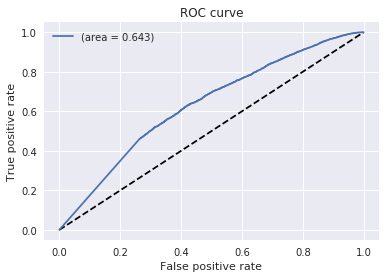

In [23]:
plot_roc(fpr_train,tpr_train)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


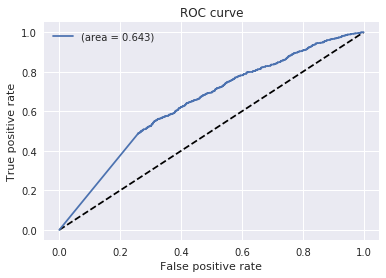

In [24]:
plot_roc(fpr_test,tpr_test)

In [27]:
## output to file for analysis
y_pred = model_m.predict(X)

In [31]:
pd.DataFrame(y_pred).rename(columns={0:'yhat'}).to_parquet("data/cnn-ypred.parquet")